<!-- # **SYMULACJA MODELU ISINGA**
Oskar Werner, Jan Wojtas -->

In [1]:
import pandas as pd
import numpy as np
from numpy.random import random, randint
import matplotlib.pyplot as plt
from numba import njit
from scipy.ndimage import convolve, generate_binary_structure
import time
from itertools import chain

Funkcje pomocnicze:

In [2]:
def num_to_matrix(num,N): 
    '''
    funkcja dokonuje zamianę liczby z systemu dziesiętnego na dwójkowy, 
    a następnie konstruuje odpowiednią macierz (reprezentująca stan modelu Isinga)
    args:
    - num: liczba zapisana w systemie dziesiętnym
    - N: wymiar wyjściowej macierzy
    '''
    n2 = N**2
    x = bin(num)[2:]

    if len(x)<n2:
        y = (n2-len(x))*'0' + x
    else:
        y = x

    matrix = [int(char) for char in y]
    matrix = np.array(matrix).reshape(N,N)

    return(matrix)

# ------------------------------------------------

def binary_to_decimal(lista_binarna):
    num = 0
    for value in lista_binarna:
        num = 2 * num + value
    return num

# ------------------------------------------------

def get_hamiltonian(matrix):
    '''
    funkcja oblicza hamiltonian konkretnego stanu modelu Isinga, reprezentowanego przez macierz (dla kraty)
    args:
    - matrix: macierz spinów reprezentująca stan modelu Isinga
    '''

    kern = np.array([
        [0,1,0],
        [1,0,1],
        [0,1,0]
    ])

    return((matrix * convolve(matrix, kern, mode = 'constant', cval = 0)).sum())

# ------------------------------------------------

def get_hamiltonian2(matrix):
    '''
    funkcja oblicza hamiltonian konkretnego stanu modelu Isinga, reprezentowanego przez macierz (dla grafu pełnego)
    args:
    - matrix: macierz spinów reprezentująca stan modelu Isinga
    '''

    spin_up_count = matrix[matrix == 1].sum()
    n2 =  (matrix.shape[0])**2
    if spin_up_count == 0 or spin_up_count == n2:
        energy = (n2)*(n2-1)/2
    else:
        energy = spin_up_count*(spin_up_count-1)/2 + (n2 - spin_up_count)*(n2 - spin_up_count-1)/2 - (n2 - spin_up_count)*spin_up_count
    return energy

# ------------------------------------------------

def get_equilibrium_distribution(N,beta,graph_type):
    '''
    funkcja wyznacza teoretyczny rozkład stacjonarny modelu Isinga
    args:
    - N: wymiar macierzy spinów 
    - beta: współczynnik 1/kT, gdzie T jest temperaturą rozpatrywanego rezerwuaru termicznego
    - graph_type: argument określający rodzaj modelu. Przyjmuje wartości 'krata' dla kraty i 'pelny' dla grafu pełnego - 
    '''


    if graph_type == 'krata':
        g = get_hamiltonian
    elif graph_type == 'pelny':
        g = get_hamiltonian2
    n = 2**(N*N)
    pi_theoretical = np.zeros(n)
    Z = 0

    for i in range(n):
        matrix = num_to_matrix(i,N)
        matrix[matrix == 0] = -1
        pi_theoretical[i] = np.exp(beta * g(matrix))
        Z += pi_theoretical[i]

    pi_theoretical = 1/Z * np.array(pi_theoretical)


    return pi_theoretical

# Symulacja dla **kraty**

## Funkcja akceptacji algorytmu Proppa - Wilsona

In [6]:
def update(beta, x, y, krata):
    '''
    funkcja wyznacza wartość funkcji akceptacji próbnika Gibbsa, wykorzystywanego w algorytmie Proppa-Wilsona (krata)
    args:
    - beta: współczynnik 1/kT, gdzie T jest temperaturą rozpatrywanego rezerwuaru termicznego
    - x: współrzędna x-owa w macierzy spinów
    - y: współrzędna y-owa w macierzy spinów
    - krata: macierz spinów 
    '''
    N = krata.shape[0]
    delta = 0
    if x>0:
        delta += krata[x-1,y]
    if x<N-1:
        delta += krata[x+1,y]
    if y>0:
        delta += krata[x,y-1]
    if y<N-1:
        delta += krata[x,y+1]

    return(np.exp(2*beta*(delta))/(np.exp(2*beta*(delta))+1))

## Pojedyncza symulacja ***modelu Isinga*** z wykorzystaniem algorytmu Proppa - Wilsona

In [47]:
N = 20
beta = 0.05

KrataP = np.ones((N,N))
KrataN = -1*np.ones((N,N))
start = time.time()
rzuty = [random()]

while (KrataN == KrataP).all() == False:
    for i in range(len(rzuty)):
        x, y = randint(0,N,2)
        KrataP[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataP) else -1
        KrataN[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataN) else -1
    rzuty +=[random() for i in range(len(rzuty))]
print(time.time()-start)

### Grafika wybranego przez algorytm stanu:

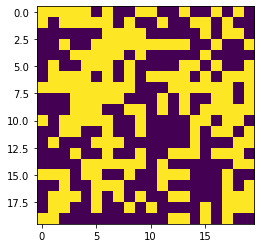

In [48]:
plt.imshow(KrataN)

## Symulacja wielokrotna. Empiryczne wyznaczanie rozkładu stacjonarnego ***modelu Isinga*** w wybranym rezerwuarze termicznym (*eng. heat bath*)

### Parametry:

In [11]:
N = 3
beta = 0.5
m = 10000
pi = [0] * 2**(N*N)

OverflowError: cannot fit 'int' into an index-sized integer

### Algorytm:

In [8]:
start = time.time()

for i in range(m):
  
    rzuty = [random()]
    KrataP = np.ones((N,N))
    KrataN = -1*np.ones((N,N))

    while (KrataN == KrataP).all() == False:

        for i in range(len(rzuty)):
            x, y = randint(0,N,2)
            KrataP[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataP) else -1
            KrataN[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataN) else -1

        rzuty += [random() for i in range(len(rzuty))]


    KrataP[KrataP == -1] = 0
    lista_binarna = np.ndarray.tolist(KrataP)
    lista_binarna = list(chain(*lista_binarna))

    pi[int(binary_to_decimal(lista_binarna))] +=1

print(time.time()-start)

16.760096073150635


### Wykresy porównawcze - empiryczny i teoretyczny rozkład stacjonarny

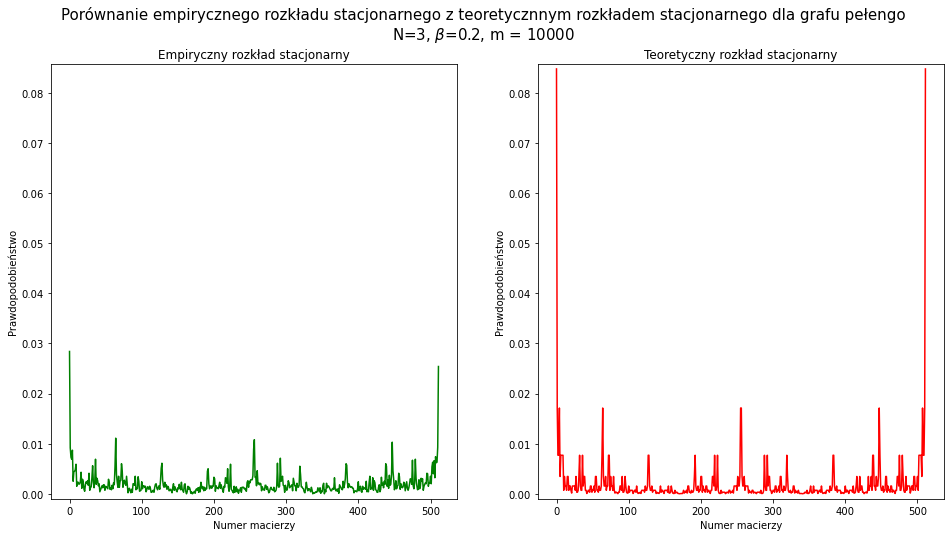

In [9]:
pi_2 = (1/m) * np.array(pi)
pi_theoretical = get_equilibrium_distribution(N = N, beta = beta, graph_type = 'krata')
b, t = min(np.concatenate((pi_2,pi_theoretical))), max(np.concatenate((pi_2,pi_theoretical)))

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(pi_2, '-', color = 'green')
plt.title('Empiryczny rozkład stacjonarny')
plt.ylim(b-0.001,t+0.001)
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(122)
plt.plot(pi_theoretical, '-', color = 'red')
plt.title('Teoretyczny rozkład stacjonarny')
plt.ylim(b-0.001,t+0.001)
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.suptitle(f'Porównanie empirycznego rozkładu stacjonarnego z teoretycznnym rozkładem stacjonarnego dla grafu pełengo\nN={N}, $\\beta$={beta}, m = {m}', fontsize = 15)
plt.savefig('Zdjecia/EmpvsTeoKrata.png')
plt.show()

# Symulacja dla **grafu pełnego**


## Funkcja akceptacji algorytmu Proppa-Wilsona

In [10]:
def update2(beta, x, y, graf, energia_grafu):
    '''
    funkcja wyznacza wartość funkcji akceptacji próbnika Gibbsa, wykorzystywanego w algorytmie Proppa-Wilsona (graf pełny)
    args:
    - beta: współczynnik 1/kT, gdzie T jest temperaturą rozpatrywanego rezerwuaru termicznego
    - x: współrzędna x-owa w macierzy spinów
    - y: współrzędna y-owa w macierzy spinów
    - graf: macierz spinów 
    - energia_grafu: suma spinów
    '''
    delta = energia_grafu - graf[x,y]

    return(np.exp(2*beta*(delta))/(np.exp(2*beta*(delta))+1))

## Pojedyncza symulacja ***modelu Isinga*** z wykorzystaniem algorytmu Proppa - Wilsona

### Parametry:

In [11]:
N = 40
beta = 0.05

KrataP = np.ones((N,N))
KrataN = -1*np.ones((N,N))
energiaP = N**2
energiaN = -N**2

### Symulacja:

In [12]:
start = time.time()

rzuty = [random()]

while (KrataN == KrataP).all() == False:
    for i in range(len(rzuty)):
        x, y = randint(0,N,2)
        KrataP_xy = KrataP[x,y]
        KrataN_xy = KrataN[x,y]
        KrataP[x,y] = 1 if rzuty[-(i+1)] < update2(beta, x, y, KrataP, energiaP) else -1
        KrataN[x,y] = 1 if rzuty[-(i+1)] < update2(beta, x, y, KrataN, energiaN) else -1

        if KrataP_xy != KrataP[x,y]:
            energiaP += 2*KrataP[x,y]
        if KrataN_xy != KrataN[x,y]:
            energiaN += 2*KrataN[x,y]
        
    rzuty +=[random() for i in range(len(rzuty))]

print('czas:', time.time()-start)

czas: 0.0039598941802978516


### Grafika wybranego przez algorytm stanu

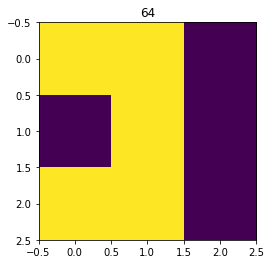

In [13]:
plt.imshow(KrataN)
plt.title(str(len(rzuty)))
plt.show()

## Symulacja wielokrotna. Empiryczne wyznaczanie rozkładu stacjonarnego ***modelu Isinga*** w wybranym rezerwuarze termicznym (*eng. heat bath*)

### Parametry:

In [15]:
N = 3
beta = 0.05
m = 10000
pi = [0] * 2**(N*N)

start = time.time()

for i in range(m):
  
    rzuty = [random()]
    KrataP = np.ones((N,N))
    KrataN = -1*np.ones((N,N))
    energiaP = N**2
    energiaN = -N**2
  
    while (KrataN == KrataP).all() == False:
        for i in range(len(rzuty)):
            x, y = randint(0,N,2)
            KrataP_xy = KrataP[x,y]
            KrataN_xy = KrataN[x,y]
            KrataP[x,y] = 1 if rzuty[-(i+1)] < update2(beta, x, y, KrataP, energiaP) else -1
            KrataN[x,y] = 1 if rzuty[-(i+1)] < update2(beta, x, y, KrataN, energiaN) else -1

            if KrataP_xy != KrataP[x,y]:
                energiaP += 2*KrataP[x,y]
            if KrataN_xy != KrataN[x,y]:
                energiaN += 2*KrataN[x,y]

        rzuty +=[random() for i in range(len(rzuty))]


    KrataP[KrataP == -1] = 0
    lista_binarna = np.ndarray.tolist(KrataP)
    lista_binarna = list(chain(*lista_binarna))

    pi[int(binary_to_decimal(lista_binarna))] +=1

print(time.time()-start)

### **Wykresy porównawcze** - empiryczny i teoretyczny rozkład stacjonarny

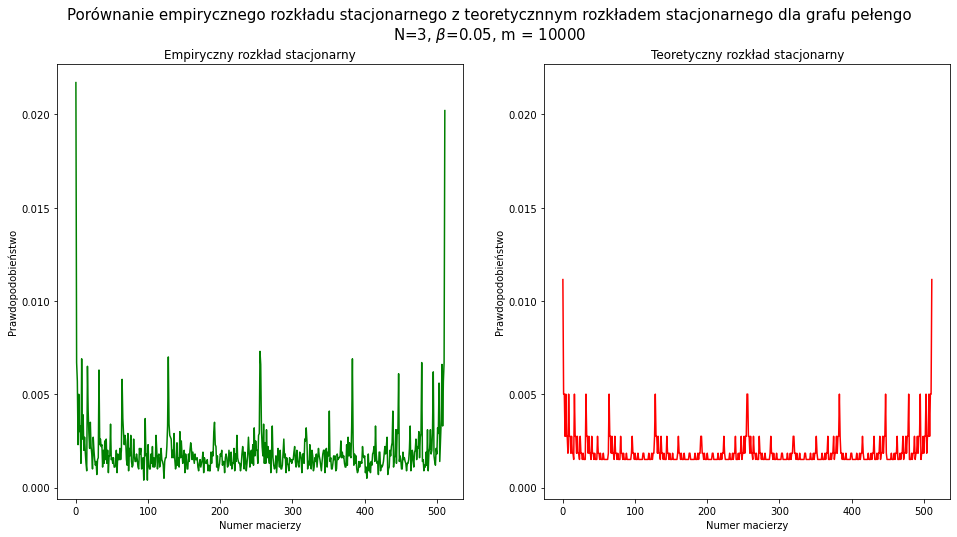

In [16]:
pi_2 = (1/m) * np.array(pi)
pi_theoretical = get_equilibrium_distribution(N = N, beta = beta, graph_type = 'pelny')
b, t = min(np.concatenate((pi_2,pi_theoretical))), max(np.concatenate((pi_2,pi_theoretical)))

plt.figure(figsize=(16,8))

plt.subplot(121)
plt.plot(pi_2, '-', color = 'green')
plt.title(f'Empiryczny rozkład stacjonarny')
plt.ylim(b-0.001,t+0.001)
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(122)
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny')
plt.ylim(b-0.001,t+0.001)
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.suptitle(f'Porównanie empirycznego rozkładu stacjonarnego z teoretycznnym rozkładem stacjonarnego dla grafu pełengo\nN={N}, $\\beta$={beta}, m = {m}', fontsize = 15)
plt.savefig('Zdjecia/EmpvsTeoPel.png')
plt.show()

# Rozkład stacjonarny w zależności od bety

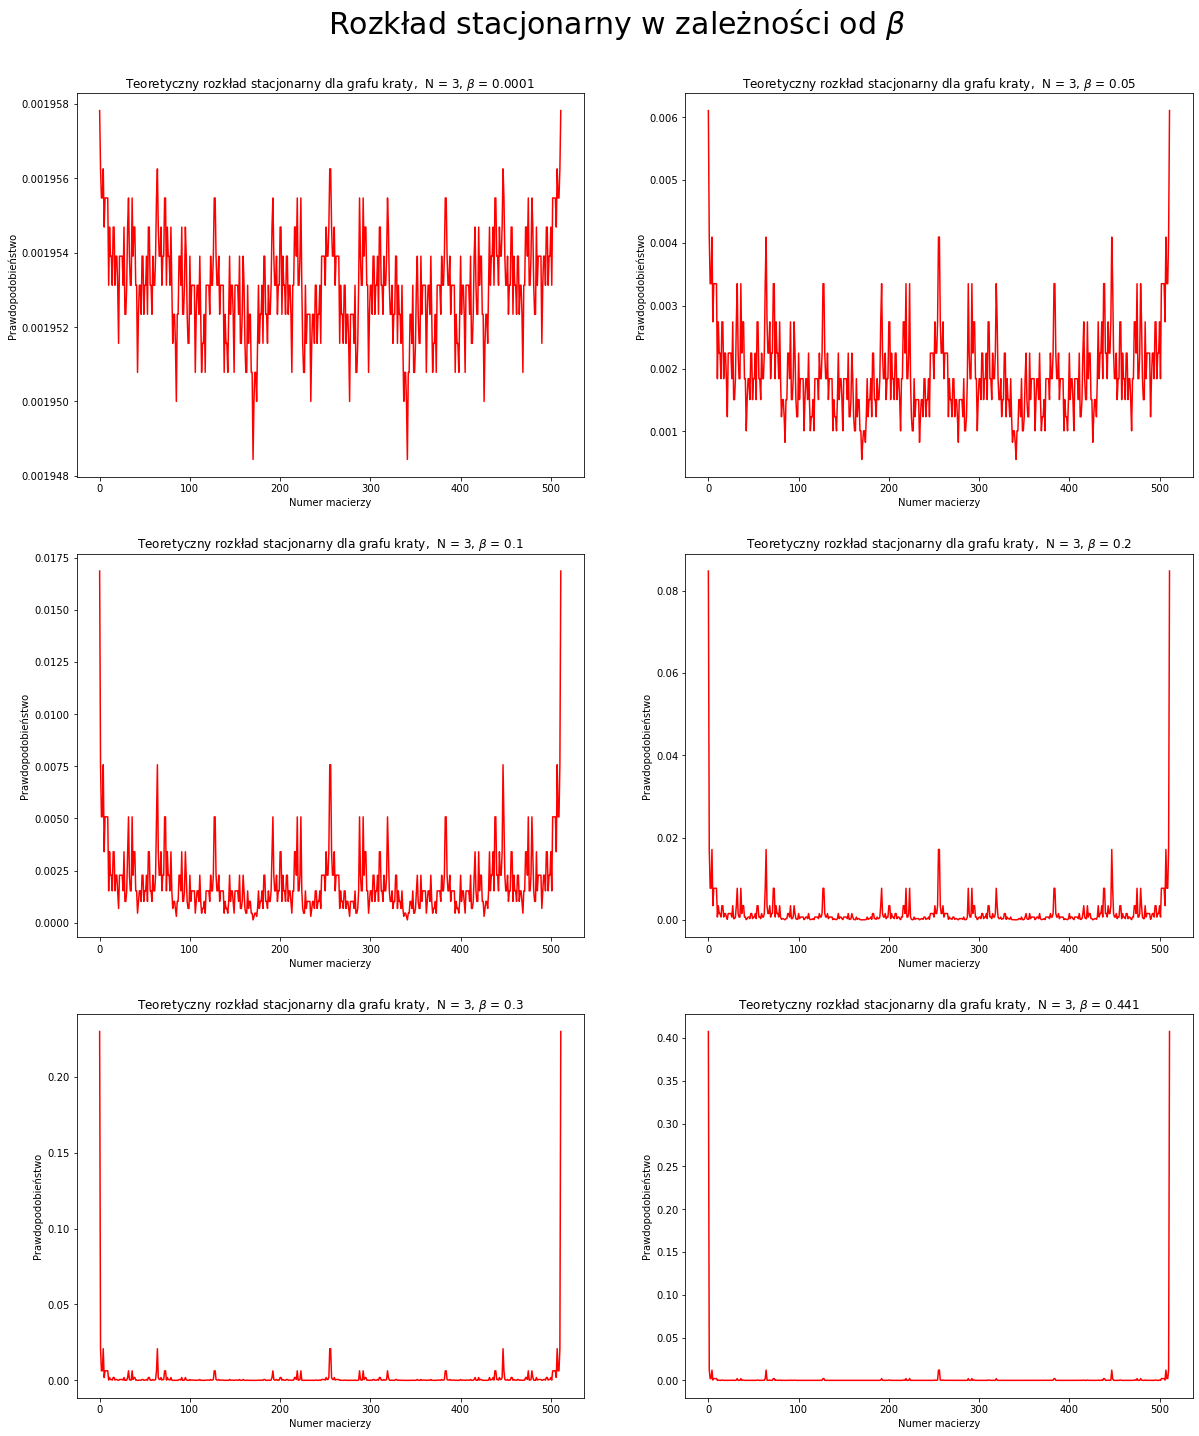

In [17]:
plt.figure(figsize=(20,24))

plt.subplot(321)
b = 0.0001
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(322)
b = 0.05
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(323)
b = 0.1
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(324)
b = 0.2
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(325)
b = 0.3
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.subplot(326)
b = 0.441
pi_theoretical = get_equilibrium_distribution(N = 3, beta = b, graph_type = 'krata')
plt.plot(pi_theoretical, '-', color = 'red')
plt.title(f'Teoretyczny rozkład stacjonarny dla grafu kraty,  N = {N}, $\\beta$ = {b}')
plt.xlabel('Numer macierzy')
plt.ylabel('Prawdopodobieństwo')

plt.suptitle(r'Rozkład stacjonarny w zależności od $\beta$', y=0.93, fontsize = 30)
plt.savefig('Zdjecia/RozkladStacjoBeta.png')
plt.show()

## Zależność tempereatury od czasu wykonania algorytmu

In [34]:
N = 6
beta = np.arange(0,0.5,step = 0.001)
czas = [0]*beta.size
m = 12

index = 0
for b in beta:
    for i in range(m):
        start = time.time()
        rzuty = [random()]
        KrataP = np.ones((N,N))
        KrataN = -1*np.ones((N,N))

        while (KrataN == KrataP).all() == False:

            for i in range(len(rzuty)):
                x, y = randint(0,N,2)
                KrataP[x,y] = 1 if rzuty[-(i+1)] < update(b, x, y, KrataP) else -1
                KrataN[x,y] = 1 if rzuty[-(i+1)] < update(b, x, y, KrataN) else -1

            rzuty += [random() for i in range(len(rzuty))]
        t = time.time()-start
        czas[index] += t
    index += 1
    print(str(b), end='\r')

KeyboardInterrupt: 

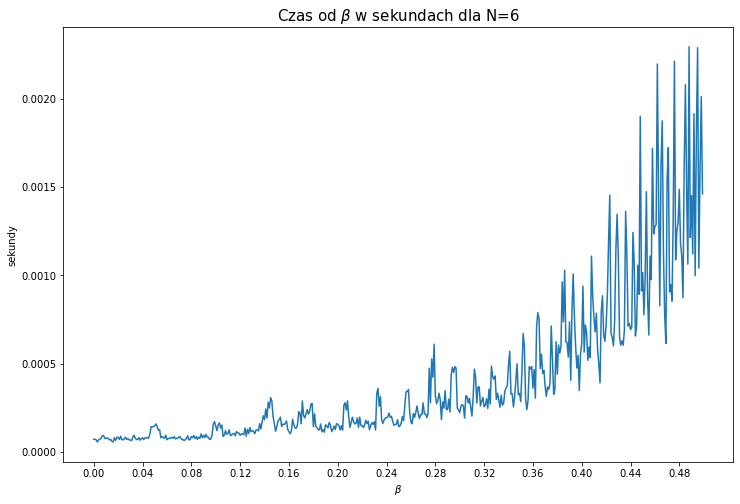

In [17]:
plt.figure(figsize=(12,8))

plt.plot(beta, np.array(czas)/1000)
plt.title(f"Czas od $\\beta$ w sekundach dla N={N}", fontsize = 15)
plt.xlabel('$\\beta$')
plt.ylabel('sekundy')
plt.xticks(np.arange(0,0.5,step = 0.04))

plt.savefig('Zdjecia/BetavsCzas.png')
plt.show()

## Czas od wymiaru macierzy dla konkretnej dużej bety

In [17]:
def model(beta):
    Ny = np.arange(3,24,step = 1)
    czas = [0]*Ny.size
    index = 0
    
    for N in Ny:
        start = time.time()
        rzuty = [random()]
        KrataP = np.ones((N,N))
        KrataN = -1*np.ones((N,N))

        while (KrataN == KrataP).all() == False:
            for i in range(len(rzuty)):
                x, y = randint(0,N,2)
                KrataP[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataP) else -1
                KrataN[x,y] = 1 if rzuty[-(i+1)] < update(beta, x, y, KrataN) else -1
            rzuty += [random() for i in range(len(rzuty))]
            t = time.time()-start

            if t > 240:
                czas[index] += t
                return czas
        czas[index] += t
        index += 1
    return czas

In [21]:
len(a)

21

In [18]:
a = model(0.45)
b = model(0.4)

In [23]:
labels

[Text(0, -5.0, '−5'),
 Text(0, 0.0, '0'),
 Text(0, 5.0, '5'),
 Text(0, 10.0, '10'),
 Text(0, 15.0, '15'),
 Text(0, 20.0, '20'),
 Text(0, 25.0, '25'),
 Text(0, 30.0, '30')]

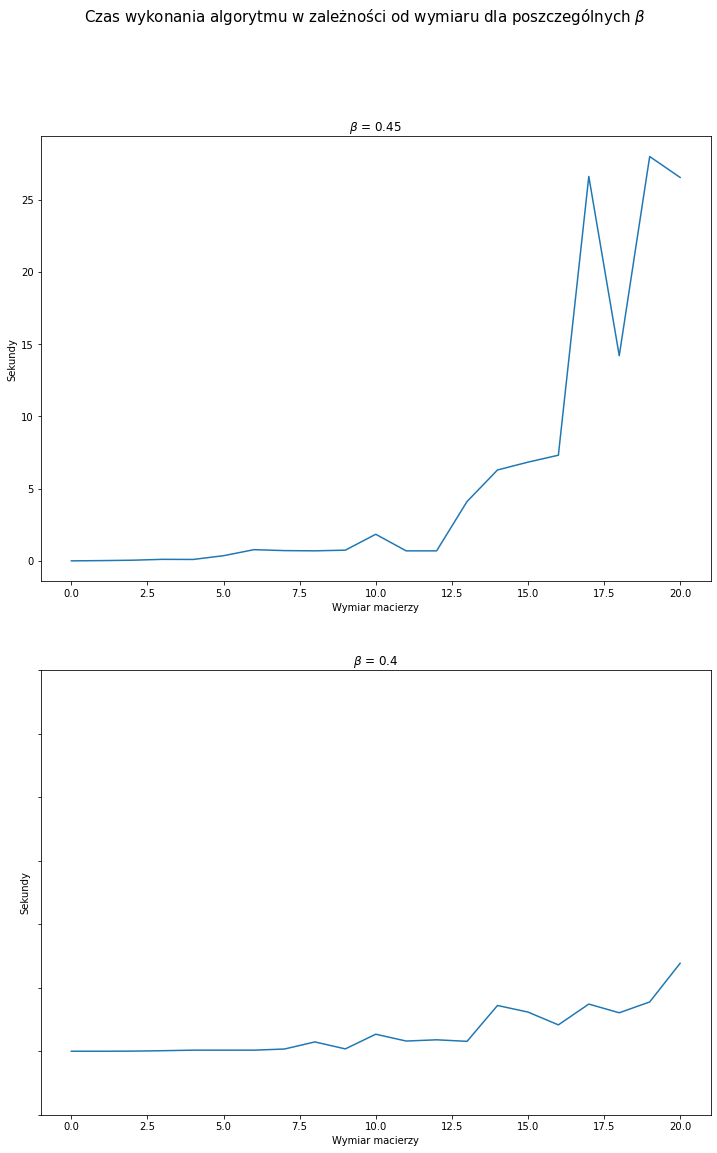

In [28]:
plt.figure(figsize=(12,18))

plt.subplot(211)
plt.plot(a)
plt.title('$\\beta$ = 0.45')
plt.xlabel('Wymiar macierzy')
plt.ylabel('Sekundy')
locs, labels = plt.yticks() 

plt.subplot(212)
plt.plot(b)
plt.title('$\\beta$ = 0.4')
plt.xlabel('Wymiar macierzy')
plt.ylabel('Sekundy')
plt.yticks(ticks = locs, labels = labels)


plt.suptitle('Czas wykonania algorytmu w zależności od wymiaru dla poszczególnych $\\beta$', fontsize = 15)
plt.savefig('Zdjecia/WymiarCzas.png')
plt.show()